https://www.kaggle.com/code/e0xextazy/basic-feature-preprocessing-stacking-upgraded

https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

https://www.kaggle.com/code/mathchi/churn-problem-for-bank-customer

Обновление датасетов

#### Импорт либ

In [ ]:
!pip install catboost mlflow --quiet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
import itertools

from pprint import pprint
from warnings import filterwarnings

import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, mean_squared_error

import mlflow
mlflow.set_tracking_uri('http://79.137.194.156:5000/')
import time
import os



filterwarnings("ignore", category=FutureWarning)

#### Включим логирование через MLflow

In [ ]:
!pip install mlflow --quiet

In [ ]:
!gdown 1Roj8P4tuI71GGsyUmbM3IjMzZ9gvQOVO

Downloading...
From: https://drive.google.com/uc?id=1Roj8P4tuI71GGsyUmbM3IjMzZ9gvQOVO
To: /content/df_hours.csv
100% 64.1M/64.1M [00:00<00:00, 73.8MB/s]


In [ ]:
!gdown 1R5aGLhexvuh6TNf_UktYpvE_k6EKdIhy
!gdown 188t3TKx2Kv8vXCbYW4bfuwOTPRUypCjI
!gdown 1YC6Vit-4pYn9ynqqs1Sc18n4A3AWxzjW
!gdown 1EAOfE8I456dZ8XnZUiYdBqzAzpasxqrs
!gdown 1cyjujW-V4ogUWKCaihiRjb4aju5sE5hx
!gdown 1yIz7OtTaINrWEnj0jJgtIQC5CSZmL1u0
!gdown 1--YyJITs0MAymrjX_44aMCftEPUdndBh
!gdown 1-7HRkHw87D97WUP6xenuJWJ9RomBQTHb
!gdown 1-AvOyhBFPRTNkOa_aX2_ewZQx-j9nrJV

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1R5aGLhexvuh6TNf_UktYpvE_k6EKdIhy 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=188t3TKx2Kv8vXCbYW4bfuwOTPRUypCjI 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1YC6Vit-4pYn9ynqqs1Sc18n4A3AWxzjW 

Access denied with the following error:

 	Cannot retrieve the p

In [ ]:
!gdown 1kWqIgao5Htm8KtcS78HC-Eujk_27PzXH

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1kWqIgao5Htm8KtcS78HC-Eujk_27PzXH 



#### Загрузка данных

In [ ]:
def read_train(dataset_name):
#    rest_agg_df = pd.read_csv('restorants_agg.csv')
    dishes = pd.read_csv('/content/freqs_dishes.csv', header=[1])
    dishes = dishes.rename(columns={'Unnamed: 0': 'customer_id'})
#    df_hours = pd.read_csv('df_hours.csv')
    train_iou_embs = pd.read_csv("train_user_iou_embedings.csv")

    df_train = pd.read_csv(f'train_{dataset_name}.csv', sep=',', compression='zip')
    df_train = df_train.drop([str(i) + '_iou' for i in range(62)], axis=1)
    df_train = df_train.set_index('customer_id').join(train_iou_embs.set_index('customer_id')).reset_index()

#    df_train = df_train.set_index('customer_id').join(df_hours.set_index('customer_id')).reset_index()
    df_train = df_train.set_index('customer_id').join(dishes.set_index('customer_id')).reset_index()
    df_train_0 = df_train[df_train['buy_post'] == 0]
    df_train_1 = df_train[df_train['buy_post'] == 1].sample(140905)
    df_train = pd.concat([df_train_0, df_train_1])
    target = df_train['buy_post']
    df_train['customer_id_binarize'] = pd.qcut(df_train['customer_id'], q=24, labels=False)
#    df_train = df_train.drop(['buy_post', 'date_diff_post', 'customer_id'] + [col for col in df_train.columns if 'iou' in col], axis=1)
    df_train = df_train.drop(['buy_post', 'date_diff_post', 'customer_id', 'days_of_week_mode'], axis=1)


    return df_train, target

In [ ]:
dishes = pd.read_csv('/content/freqs_dishes.csv', header=[1])
dishes = dishes.rename(columns={'Unnamed: 0': 'customer_id'})

In [ ]:
dishes

,customer_id,-1.0,16625.0,16875.0,17024.0,17115.0,17195.0,17230.0,17253.0,17533.0,...,265516.0,322949.0,347942.0,362492.0,425608.0,446587.0,524994.0,558419.0,768436.0,818129.0
0,29891,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,30477,11.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,10.0
2,31426,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,9.0,0.0,4.0,21.0,7.0,2.0,2.0
3,44491,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,44939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612329,46632765,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
612330,46639170,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
612331,46654016,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
612332,46661804,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0


###### import libs

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
#from sklearn.ensemble import VotingClassifier


from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

### classifier

In [ ]:
model_metrics = []
from functools import partial

def get_metrics(y_true, y_pred, y_proba):
  SC_Recall = recall_score(y_true, y_pred)
  SC_Precision = precision_score(y_true, y_pred)
  SC_f1 = f1_score(y_true, y_pred, average='weighted')
  SC_f1_pos = f1_score(y_true, y_pred)
  SC_f1_neg = f1_score(1-y_true, 1-y_pred)
  SC_accuracy = accuracy_score(y_true, y_pred)
  SC_roc_auc = roc_auc_score(y_true, y_proba)

  cm = confusion_matrix(y_true, y_pred)
  print(cm)
  ndf = [SC_Recall, SC_Precision, SC_f1, SC_accuracy, SC_roc_auc, SC_f1_pos,SC_f1_neg]#, SC_cv_score, SC_cv_stdev)]
  columns = ['Recall','Precision','F1 Score Weighted', 'Accuracy', 'ROC-AUC Score', 'F1-Positive', 'F1-negative']
  return dict(zip(columns, ndf))

def prepare_submit(trained_model, X_test):
  y_test = trained_model.predict(X_test)
  X_submit = pd.DataFrame(X_test['customer_id'])
  X_submit['buy_post'] = y_test
  return X_submit

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#TRAIN_DATASET_NAME = 'train_user_order_aggs_v2.csv'
#TEST_DATASET_NAME = 'test_user_order_aggs_v2.csv'
datasets = 'user_order_aggs_v13'.split()
# df_test = pd.read_csv(f'test_user_order_aggs_v2.csv', sep=',')

dataset_name = datasets[0]

df_train, target = read_train(dataset_name)


<ipython-input-75-370c691a1b0e>:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_iou_embs = pd.read_csv("train_user_iou_embedings.csv")


In [ ]:
cols_to_drop = [
     '0_menu_embed_cut16',
 '1_menu_embed_cut16',
 '2_menu_embed_cut16',
 '3_menu_embed_cut16',
 '4_menu_embed_cut16',
 '5_menu_embed_cut16',
 '6_menu_embed_cut16',
 '7_menu_embed_cut16',
 '8_menu_embed_cut16',
 '9_menu_embed_cut16',
 '10_menu_embed_cut16',
 '11_menu_embed_cut16',
 '12_menu_embed_cut16',
 '13_menu_embed_cut16',
 '14_menu_embed_cut16',
 '15_menu_embed_cut16',
]

In [ ]:
df_train.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:

#dataset_name = 'user_order_aggs'
model_name = 'CatBoost_Colab_002'
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)

folds = 1

# Train-Test Separation
X_train, X_val, y_train, y_val = train_test_split(df_train, target, test_size=(0.25), random_state=12345, stratify=target)

# # Add wieghted
# weights_train = []

# for i in y_train.values:
#     if i == 1:
#         weights_train.append(weights[1])
#     else:
#         weights_train.append(weights[0])

# weights_val = []

# for i in y_val.values:
#     if i == 1:
#         weights_val.append(weights[1])
#     else:
#         weights_val.append(weights[0])


# Add Pool
train_dataset = Pool(X_train,
                    y_train,
                    )

val_dataset = Pool(X_val,
                    y_val,
                    )

# Define model and run train cycle
model = CatBoostClassifier(random_state=13, task_type='GPU')

grid = {'learning_rate': [0.2],
      'depth': [5],
#       'l2_leaf_reg': [7, 9, 11, 13],
      'n_estimators':[200],
#         'random_strength': np.linspace(1.1, 1.2, 10),
}


# best_params = {'learning_rate': 0.15, 'depth': 8, 'l2_leaf_reg': 3, 'n_estimators': 50 }
randomized_search_result = model.randomized_search(grid,
                                                  X=df_train,
                                                   y=target,
                                                n_iter=4,
                                                plot=True,
                                                cv=2)
best_params = randomized_search_result['params']

trained_model = CatBoostClassifier(random_state=101010,
                                    **best_params,
                                    task_type='GPU',
                                    thread_count = -1,
                                    ).fit(train_dataset)


    # Log metric to MLflow


#   X_submit = prepare_submit(trained_model, df_test)
#   X_submit.to_csv(f'{dataset_name}_{model_name}_submit.csv', index=False)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6506602	test: 0.6512481	best: 0.6512481 (0)	total: 151ms	remaining: 30.1s
1:	learn: 0.6311248	test: 0.6320235	best: 0.6320235 (1)	total: 301ms	remaining: 29.8s
2:	learn: 0.6208877	test: 0.6220135	best: 0.6220135 (2)	total: 468ms	remaining: 30.7s
3:	learn: 0.6147295	test: 0.6160464	best: 0.6160464 (3)	total: 624ms	remaining: 30.6s
4:	learn: 0.6106339	test: 0.6120428	best: 0.6120428 (4)	total: 750ms	remaining: 29.3s
5:	learn: 0.6078832	test: 0.6094370	best: 0.6094370 (5)	total: 903ms	remaining: 29.2s
6:	learn: 0.6058958	test: 0.6075135	best: 0.6075135 (6)	total: 1.06s	remaining: 29.3s
7:	learn: 0.6044217	test: 0.6060586	best: 0.6060586 (7)	total: 1.21s	remaining: 29.1s
8:	learn: 0.6031090	test: 0.6048204	best: 0.6048204 (8)	total: 1.36s	remaining: 28.9s
9:	learn: 0.6023295	test: 0.6041658	best: 0.6041658 (9)	total: 1.47s	remaining: 27.9s
10:	learn: 0.6017010	test: 0.6035681	best: 0.6035681 (10)	total: 1.53s	remaining: 26.3s
11:	learn: 0.6013172	test: 0.6032318	best: 0.6032318

In [ ]:
best_params

{'depth': 5, 'iterations': 200, 'learning_rate': 0.2}

In [ ]:
best_params['n_estimators'] = 120
del best_params['iterations']
trained_model = CatBoostClassifier(random_state=101010,
                                       **best_params,
                                       task_type='GPU',
                                       thread_count = -1,
                                       ).fit(train_dataset)

0:	learn: 0.6493892	total: 16ms	remaining: 1.91s
1:	learn: 0.6308910	total: 40.8ms	remaining: 2.41s
2:	learn: 0.6222536	total: 60.9ms	remaining: 2.37s
3:	learn: 0.6164383	total: 76.5ms	remaining: 2.22s
4:	learn: 0.6109353	total: 91ms	remaining: 2.09s
5:	learn: 0.6082121	total: 107ms	remaining: 2.04s
6:	learn: 0.6063284	total: 124ms	remaining: 2.01s
7:	learn: 0.6048911	total: 140ms	remaining: 1.96s
8:	learn: 0.6038411	total: 156ms	remaining: 1.92s
9:	learn: 0.6031873	total: 170ms	remaining: 1.87s
10:	learn: 0.6026380	total: 184ms	remaining: 1.82s
11:	learn: 0.6022166	total: 200ms	remaining: 1.8s
12:	learn: 0.6016311	total: 220ms	remaining: 1.81s
13:	learn: 0.6013423	total: 235ms	remaining: 1.77s
14:	learn: 0.6007735	total: 249ms	remaining: 1.74s
15:	learn: 0.6005630	total: 264ms	remaining: 1.72s
16:	learn: 0.6003995	total: 274ms	remaining: 1.66s
17:	learn: 0.6001376	total: 284ms	remaining: 1.61s
18:	learn: 0.5999410	total: 295ms	remaining: 1.57s
19:	learn: 0.5998104	total: 305ms	remaini

In [ ]:
best_params

{'depth': 6,
 'l2_leaf_reg': 9,
 'random_strength': 1.1333333333333333,
 'learning_rate': 0.1,
 'n_estimators': 200}

In [ ]:
X = X_train
with mlflow.start_run(run_name=f'grafML_{dataset_name}_{model_name}_Train'):
    y_pred = trained_model.predict(X)
    y_proba = trained_model.predict_proba(X)[:,1]
    metrics_dict = get_metrics(y_train, y_pred, y_proba)
    mlflow.log_metrics(metrics_dict)
    mlflow.log_param('catboost', str(best_params))

X = X_val
with mlflow.start_run(run_name=f'grafML_{dataset_name}_{model_name}_Validation'):
    y_pred = trained_model.predict(X)
    y_proba = trained_model.predict_proba(X)[:,1]
    metrics_dict = get_metrics(y_val, y_pred, y_proba)
    mlflow.log_metrics(metrics_dict)
    mlflow.log_param('catboost', str(best_params))


trained_model.save_model(f'grafML_user_order_aggs_v10_CatBoost_Colab_002_Validation.cbm')

[[110473  30939]
 [ 51246  54433]]
[[36685 10453]
 [17380 17846]]


In [ ]:
best_params['n_estimators'] = 200
del best_params['iterations']
trained_model = CatBoostClassifier(random_state=101010,
                                       **best_params,
                                       task_type='GPU',
                                       thread_count = -1,
                                       ).fit(df_train, target)

0:	learn: 0.6676165	total: 12ms	remaining: 2.39s
1:	learn: 0.6516955	total: 23.7ms	remaining: 2.35s
2:	learn: 0.6418301	total: 35.5ms	remaining: 2.33s
3:	learn: 0.6360901	total: 47.4ms	remaining: 2.32s
4:	learn: 0.6314910	total: 58.6ms	remaining: 2.29s
5:	learn: 0.6275762	total: 72.4ms	remaining: 2.34s
6:	learn: 0.6231315	total: 83.7ms	remaining: 2.31s
7:	learn: 0.6203994	total: 95.3ms	remaining: 2.29s
8:	learn: 0.6181459	total: 106ms	remaining: 2.25s
9:	learn: 0.6162597	total: 118ms	remaining: 2.23s
10:	learn: 0.6146745	total: 128ms	remaining: 2.21s
11:	learn: 0.6133395	total: 140ms	remaining: 2.19s
12:	learn: 0.6121302	total: 152ms	remaining: 2.18s
13:	learn: 0.6110872	total: 162ms	remaining: 2.15s
14:	learn: 0.6102547	total: 174ms	remaining: 2.14s
15:	learn: 0.6095455	total: 185ms	remaining: 2.13s
16:	learn: 0.6088204	total: 195ms	remaining: 2.1s
17:	learn: 0.6082278	total: 203ms	remaining: 2.05s
18:	learn: 0.6064467	total: 215ms	remaining: 2.05s
19:	learn: 0.6059861	total: 224ms	re

In [ ]:
trained_model

Feature importance

In [ ]:
f_i = trained_model.get_feature_importance()
f_n = X_train.columns.to_list()
sorted(zip(f_i, f_n))

[(0.0, '10.0'),
 (0.0, '11.0'),
 (0.0, '15.0'),
 (0.0, '16.0'),
 (0.0, '20.0'),
 (0.0, '21.0'),
 (0.0, '23.0'),
 (0.0, '24.0'),
 (0.0, '25.0'),
 (0.0, '26.0'),
 (0.0, '29.0'),
 (0.0, '31.0'),
 (0.0, '35.0'),
 (0.0, '37.0'),
 (0.0, '38.0'),
 (0.0, '40.0'),
 (0.0, '41.0'),
 (0.0, '42.0'),
 (0.0, '44.0'),
 (0.0, '46.0'),
 (0.0, '48.0'),
 (0.0, '49.0'),
 (0.0, '50.0'),
 (0.0, '54.0'),
 (0.0, '56.0'),
 (0.0, '9.0'),
 (0.0, 'F_Quartile_value_2_sum'),
 (0.0, 'R_Quartile_value_3_sum'),
 (0.0, 'delta_days_order_count'),
 (0.0, 'revenue_sum_min_second'),
 (0.0, 'rfm_median_nunique'),
 (0.0, 'rfm_sum_sum'),
 (0.0, 'tmp.12'),
 (0.0, 'tmp.14'),
 (0.0, 'tmp.15'),
 (0.0, 'tmp.2'),
 (0.0, 'tmp.5'),
 (0.0, 'tmp.8'),
 (0.00018221750213183184, 'tmp.7'),
 (0.00018313165869263728, '39.0'),
 (0.0003164017253486431, '61.0'),
 (0.0004139023850098366, '28.0'),
 (0.0004830866412044607, 'tmp.3'),
 (0.0005041136333818504, 'tmp.20'),
 (0.0005653647018545306, '13.0'),
 (0.0006319872818223511, 'M_Quartile_value_2_su

In [ ]:
!pip install shap

In [ ]:
import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer(df_train.sample(10000))

KeyboardInterrupt: ignored

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
!gdown 1vF-Co6Qy9hlJlx1KbTKLcN6w_IdfM9g0
!gdown 1SyUP7--E5Q3xSyjilYp1UmLt4QsW_FHq
!gdown 1ATpFjeNm-o2CFsAmkv8E8UBV1lF1AFY5

Downloading...
From: https://drive.google.com/uc?id=1vF-Co6Qy9hlJlx1KbTKLcN6w_IdfM9g0
To: /content/test_user_order_aggs_v10.csv
100% 43.9M/43.9M [00:00<00:00, 85.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SyUP7--E5Q3xSyjilYp1UmLt4QsW_FHq
To: /content/test_user_text_iou_embeds (1).csv
100% 177M/177M [00:03<00:00, 45.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ATpFjeNm-o2CFsAmkv8E8UBV1lF1AFY5
To: /content/test_user_order_aggs_v13.csv
100% 94.0M/94.0M [00:03<00:00, 24.4MB/s]


In [ ]:
df_test = pd.read_csv('/content/test_user_order_aggs_v13.csv', compression='zip')

In [ ]:
df_test['customer_id_binarize'] = pd.qcut(df_test['customer_id'], q=24, labels=False)

In [ ]:
# rest_agg_df = pd.read_csv('test_restorants_agg.csv')
#df_test = df_test.set_index('customer_id').join(rest_agg_df.set_index('customer_id')).reset_index()

In [ ]:
test_iou_embs = pd.read_csv("test_user_iou_embedings.csv")

In [ ]:
df_test = df_test.set_index('customer_id').join(test_iou_embs.set_index('customer_id')).reset_index()

In [ ]:
df_test = df_test[df_train.columns.to_list() + ['customer_id']]

In [ ]:
df_test

In [ ]:
X_submit = prepare_submit(trained_model, df_test)

In [ ]:
X_submit['proba'] = trained_model.predict_proba(df_test)[:, 1]

In [ ]:

# X_submit.to_csv(f'{dataset_name}_{model_name}_submit.csv', index=False, sep=';')

In [ ]:
X_submit['new_pred'] = X_submit['proba'] >  X_submit['proba'].median()
X_submit['new_pred'] = X_submit['new_pred'].astype(int)
X_submit['buy_post'] = X_submit['new_pred']
X_submit = X_submit.drop(['new_pred', 'proba'], axis=1)


# X_submit.to_csv(f'{dataset_name}_{model_name}_submit_with_proba_thehold.csv', index=False, sep=';')

In [ ]:
X_submit

,customer_id,buy_post
0,226048,1
1,292608,1
2,313088,1
3,385792,0
4,402176,0
...,...,...
111511,43737087,0
111512,44630015,0
111513,44766975,0
111514,44930559,0


In [ ]:
submit_old = pd.read_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW6.csv', sep=';')

In [ ]:
submit_old

,customer_id,buy_post
0,52341,1
1,69175,1
2,73427,1
3,134577,0
4,156357,0
...,...,...
112329,46540272,0
112330,46569275,0
112331,46601088,0
112332,46632765,0


In [ ]:
df_join = submit_old.set_index('customer_id').join(X_submit.set_index('customer_id'), lsuffix='_old')

In [ ]:
df_join.corr()

,buy_post_old,buy_post
buy_post_old,1.000000,0.738857
buy_post,0.738857,1.000000


In [ ]:
df_join = df_join.fillna(0)

In [ ]:
df_join['buy_post'] = df_join['buy_post'].astype(int)

In [ ]:
df_join.corr()

,buy_post_old,buy_post
buy_post_old,1.000000,0.740739
buy_post,0.740739,1.000000


In [ ]:
df_join.reset_index()[['customer_id', 'buy_post']].to_csv(f'{dataset_name}_{model_name}_submit_with_proba_thehold_NEW7.csv', index=False, sep=';')

In [ ]:
df_join

,buy_post_old,buy_post,proba
customer_id,,,
52341,1,1,0.579422
69175,1,1,0.876108
73427,1,1,0.964701
134577,0,0,0.091812
156357,0,0,0.454866
...,...,...,...
46540272,0,0,0.233661
46569275,0,0,0.383195
46601088,0,0,0.379692


In [ ]:
df_join.groupby('buy_post').agg({'buy_post_old': ['sum']})

,buy_post_old
,sum
buy_post,
0,5973
1,49785


In [ ]:
df_train.to_csv("df_train_v8.csv", index=False)

In [ ]:
df_test.to_csv("df_test_v8.csv", index=False)

In [ ]:
X_submit['new_pred'] = X_submit['proba'] >  X_submit['proba'].median()
X_submit['new_pred'] = X_submit['new_pred'].astype(int)
X_submit['buy_post'] = X_submit['new_pred']
X_submit = X_submit.drop(['new_pred', 'proba'], axis=1)

X_submit.to_csv(f'{dataset_name}_{model_name}_submit_with_proba_thehold.csv', index=False, sep=';')

In [ ]:
X_submit['buy_post'].value_counts()

In [ ]:
!head /content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW5.csv

customer_id;buy_post
52341;1
69175;1
73427;1
134577;0
156357;0
161390;0
168512;1
179897;1
180373;0


Сделать предикт на средний по всем

In [ ]:
preds1 = pd.read_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW.csv', sep=';').set_index('customer_id')
preds2 = pd.read_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW2.csv', sep=';').set_index('customer_id')
preds3 = pd.read_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW3.csv', sep=';').set_index('customer_id')
preds4 = pd.read_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW4.csv', sep=';').set_index('customer_id')
preds5 = pd.read_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW5.csv', sep=';').set_index('customer_id')

In [ ]:
df_preds = preds1.join(preds2, lsuffix='1').join(preds3, lsuffix='2').join(preds4, lsuffix='3').join(preds5, lsuffix='4')

In [ ]:
df_new_preds = df_preds.apply(sum, axis=1)

In [ ]:
df_preds.apply(sum, axis=1).value_counts()

0    47993
5    47381
2     5642
3     5311
1     3120
4     2887
dtype: int64

In [ ]:
df_new_preds[df_new_preds < 3]= 0
df_new_preds[df_new_preds >= 3]= 1

In [ ]:
pd.DataFrame(df_new_preds).rename(columns={0: 'buy_post'}).reset_index().to_csv('/content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW6.csv', index=False, sep=';')

In [ ]:
!head /content/user_order_aggs_v13_CatBoost_Colab_002_submit_with_proba_thehold_NEW6.csv

customer_id;buy_post
52341;1
69175;1
73427;1
134577;0
156357;0
161390;1
168512;1
179897;1
180373;0


In [ ]:
 df_tmp = df_preds.apply(sum, axis=1).reset_index()

In [ ]:
df_strange_users = df_tmp[(df_tmp[0] > 0).values & (df_tmp[0] < 5).values]

In [ ]:
df_normal_users = df_tmp[(df_tmp[0] == 0).values | (df_tmp[0] == 5).values]

In [ ]:
df_test_str = df_strange_users.set_index("customer_id").join(df_test.set_index('customer_id'))
df_test_nrm = df_normal_users.set_index("customer_id").join(df_test.set_index('customer_id'))

In [ ]:
df_normal_users

,customer_id,0
0,52341,5
1,69175,5
2,73427,5
3,134577,0
6,168512,5
...,...,...
112328,46537253,0
112329,46540272,0
112330,46569275,0
112331,46601088,0


In [ ]:

model_str_nrm = CatBoostClassifier(n_estimators=100)

In [ ]:
df_test_str['is_strange'] = 1
df_test_nrm['is_strange'] = 0

<Axes: >

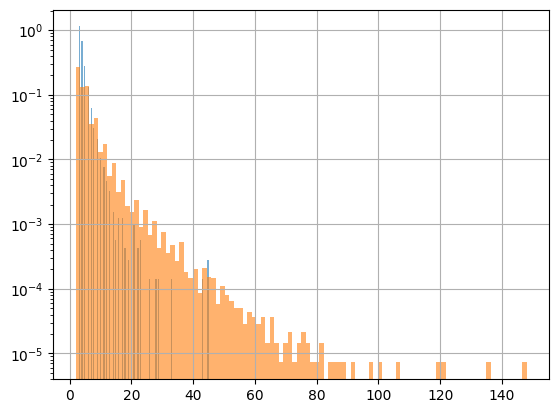

In [ ]:
df_test_str['revenue_sum_count'].hist(bins=100, alpha=0.6, density=True, log=True)
df_test_nrm['revenue_sum_count'].hist(bins=100, alpha=0.6, density=True, log=True)

<Axes: >

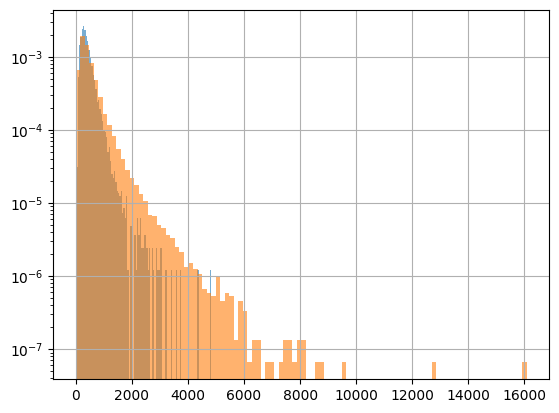

In [ ]:
df_test_str['rfm_median_sum'].hist(bins=100, alpha=0.6, density=True, log=True)
df_test_nrm['rfm_median_sum'].hist(bins=100, alpha=0.6, density=True, log=True)

<Axes: >

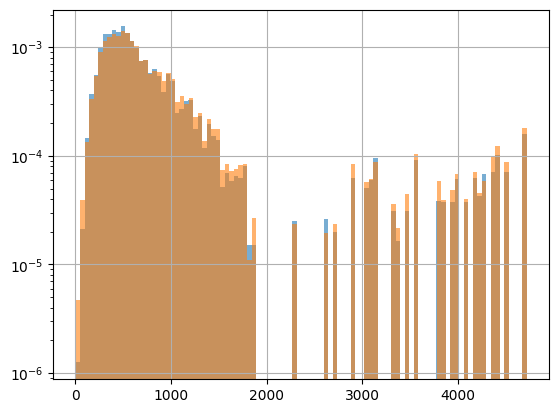

In [ ]:
df_test_str['client_count_max'].hist(bins=100, alpha=0.6, density=True, log=True)
df_test_nrm['client_count_max'].hist(bins=100, alpha=0.6, density=True, log=True)

In [ ]:
df_test_str['revenue_sum_count'].value_counts()  / df_test_str.shape[0]

3     0.479245
4     0.284670
5     0.118219
6     0.055366
7     0.026238
8     0.012795
9     0.008844
10    0.004481
11    0.003243
12    0.001946
13    0.001356
14    0.000649
17    0.000531
16    0.000531
21    0.000413
23    0.000236
15    0.000236
22    0.000177
18    0.000177
20    0.000118
45    0.000118
19    0.000118
28    0.000059
29    0.000059
26    0.000059
43    0.000059
33    0.000059
Name: revenue_sum_count, dtype: float64

In [ ]:
df_test_nrm['revenue_sum_count'].value_counts() / df_test_nrm.shape[0]

3.0      0.389519
4.0      0.193292
5.0      0.120924
6.0      0.075471
7.0      0.051586
           ...   
69.0     0.000010
80.0     0.000010
100.0    0.000010
86.0     0.000010
98.0     0.000010
Name: revenue_sum_count, Length: 90, dtype: float64

In [ ]:
df_all = pd.concat([df_test_str, df_test_nrm])

In [ ]:
df_all['delta_days_order_mean'] = df_all['delta_days_order_mean'].round()

In [ ]:
df_all[['delta_days_order_mean', 'is_strange']].groupby('is_strange').mean()

,delta_days_order_mean
is_strange,
0,8.374730
1,12.567453


In [ ]:
is_strange = df_all['is_strange']

In [ ]:
model_str_nrm.fit(df_all.drop(['is_strange', 0], axis=1), is_strange)

Learning rate set to 0.5
0:	learn: 0.4304875	total: 95.6ms	remaining: 9.46s
1:	learn: 0.3262412	total: 188ms	remaining: 9.23s
2:	learn: 0.2973487	total: 273ms	remaining: 8.83s
3:	learn: 0.2865661	total: 362ms	remaining: 8.68s
4:	learn: 0.2792287	total: 460ms	remaining: 8.73s
5:	learn: 0.2748135	total: 549ms	remaining: 8.6s
6:	learn: 0.2661276	total: 629ms	remaining: 8.36s
7:	learn: 0.2642608	total: 709ms	remaining: 8.15s
8:	learn: 0.2605125	total: 799ms	remaining: 8.08s
9:	learn: 0.2567637	total: 893ms	remaining: 8.04s
10:	learn: 0.2539733	total: 980ms	remaining: 7.93s
11:	learn: 0.2504112	total: 1.08s	remaining: 7.91s
12:	learn: 0.2473356	total: 1.16s	remaining: 7.75s
13:	learn: 0.2457311	total: 1.23s	remaining: 7.59s
14:	learn: 0.2439268	total: 1.33s	remaining: 7.52s
15:	learn: 0.2434782	total: 1.41s	remaining: 7.41s
16:	learn: 0.2415960	total: 1.49s	remaining: 7.29s
17:	learn: 0.2414082	total: 1.56s	remaining: 7.09s
18:	learn: 0.2407251	total: 1.65s	remaining: 7.01s
19:	learn: 0.240

In [ ]:
f1_score(df_all['is_strange'], model_str_nrm.predict(df_all))

0.7061324196567367

In [ ]:
df_all

,0,delta_days_order_mean,delta_days_order_min,delta_days_order_max,delta_days_order_std,delta_days_order_nunique,delta_days_order_count,revenue_last,revenue_sum_mean,revenue_sum_sum,...,14_menu_embed_cut16,15_menu_embed_cut16,rest_target_avg,rest_target_max,rest_date_diff_avg,rest_date_diff_max,client_count_avg,client_count_max,customer_id_binarize,is_strange
customer_id,,,,,,,,,,,,,,,,,,,,,
156357,1,21.0,5.0,37.0,22.627417,2.0,2.0,749.95,558.963333,1676.89,...,0.036195,0.690956,0.712402,0.721223,31.269231,32.0,461.000000,556.0,0.0,1
161390,3,16.0,14.0,17.0,2.121320,2.0,2.0,489.97,780.276667,2340.83,...,-0.142267,0.020506,0.776715,0.821438,27.000000,29.0,1111.727273,3853.0,0.0,1
196270,3,2.0,0.0,5.0,1.511858,5.0,8.0,219.98,170.208889,1531.88,...,-0.065899,0.176761,0.820521,0.832994,16.157895,17.0,923.894737,982.0,0.0,1
197835,3,16.0,4.0,28.0,16.970563,2.0,2.0,329.98,547.633333,1642.90,...,-0.086143,-0.369475,0.825520,0.839662,19.555556,21.0,241.000000,294.0,0.0,1
198718,2,10.0,8.0,11.0,2.121320,2.0,2.0,384.95,290.630000,871.89,...,-0.410947,0.165191,0.861496,0.861496,16.000000,16.0,361.000000,361.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46537253,0,0.0,0.0,1.0,0.707107,2.0,2.0,2640.00,2126.593333,6379.78,...,-0.056350,-0.098300,0.847501,0.892265,21.529412,28.0,262.823529,362.0,23.0,0
46540272,0,0.0,0.0,0.0,0.000000,1.0,2.0,139.99,441.633333,1324.90,...,0.322471,-0.115682,0.874000,0.874000,17.000000,17.0,500.000000,500.0,23.0,0
46569275,0,0.0,0.0,1.0,0.707107,2.0,2.0,1.00,377.313333,1131.94,...,-0.450841,-0.151707,0.899264,0.917313,13.250000,20.0,364.500000,387.0,23.0,0


In [ ]:
f_i = model_str_nrm.get_feature_importance()
f_n = df_all.columns.to_list()
sorted(zip(f_i, f_n))

[(0.0, '15_iou'),
 (0.0, '20_iou'),
 (0.0, '21_iou'),
 (0.0, '22_iou'),
 (0.0, '23_iou'),
 (0.0, '24_iou'),
 (0.0, '26_iou'),
 (0.0, '33_iou'),
 (0.0, '38_iou'),
 (0.0, '3_iou'),
 (0.0, '43_iou'),
 (0.0, '46_iou'),
 (0.0, '47_iou'),
 (0.0, 'F_Quartile_value_1_sum'),
 (0.0, 'F_Quartile_value_3_sum'),
 (0.0, 'M_Quartile_value_2_sum'),
 (0.0, 'R_Quartile_value_2_sum'),
 (0.0, 'R_Quartile_value_3_sum'),
 (0.0, 'days_of_week_mode'),
 (0.0, 'delta_days_order_count'),
 (0.0, 'revenue_last'),
 (0.0, 'revenue_sum_max_second'),
 (0.0, 'revenue_sum_mean'),
 (0.0, 'revenue_sum_std'),
 (0.0, 'rfm_count_max'),
 (0.0, 'rfm_count_nunique'),
 (0.0, 'rfm_median_mean'),
 (0.0, 'rfm_sum_mean'),
 (0.0, 'rfm_sum_min'),
 (0.0, 'rfm_sum_nunique'),
 (0.0009548937994079343, '60_iou'),
 (0.01070381251761393, 'day_of_week_last'),
 (0.013397402919778124, '54_iou'),
 (0.014565667326381348, '13_iou'),
 (0.017252632323892497, '18_iou'),
 (0.017538069386805927, '14_iou'),
 (0.018293113479157543, '32_iou'),
 (0.0191024

KeyError: ignored

<Axes: >

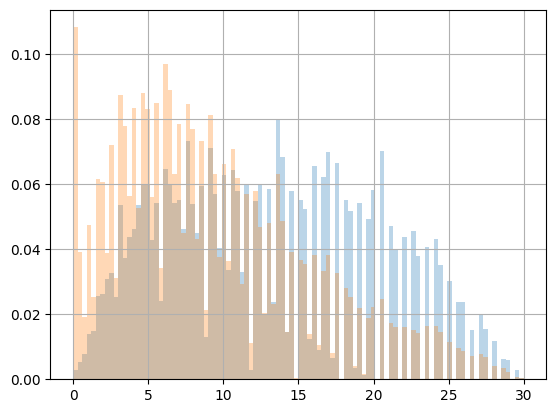

In [ ]:
df_test_str['delta_days_order_mean'].hist(bins=100, alpha=0.3, density=True)
df_test['delta_days_order_mean'].hist(bins=100, alpha=0.3, density=True)

In [ ]:
df_test['delta_days_order_mean']

0          2.750000
1          4.727273
2          7.166667
3          0.000000
4          2.500000
            ...    
111511    11.333333
111512    11.500000
111513     6.333333
111514    10.500000
111515     0.500000
Name: delta_days_order_mean, Length: 111516, dtype: float64

<Axes: >

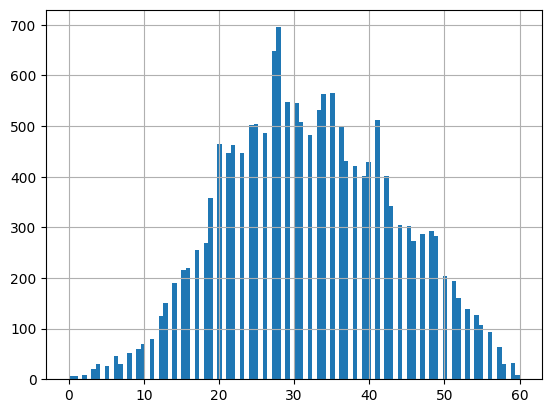

In [ ]:
df_test_str['max_min_delta_days'].hist(bins=100)

<Axes: >

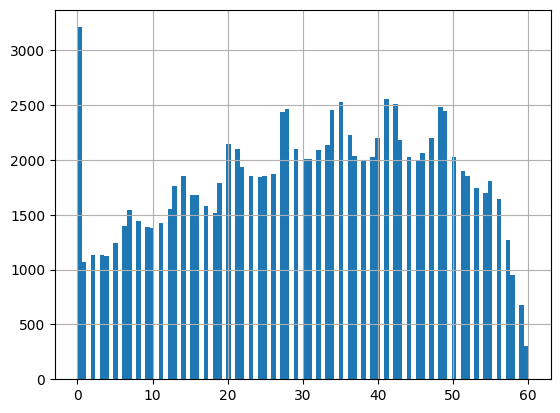

In [ ]:
df_test['max_min_delta_days'].hist(bins=100)

In [ ]:
df_test_str['delta_days_order_mean'].hist(bins=100)

<Axes: >

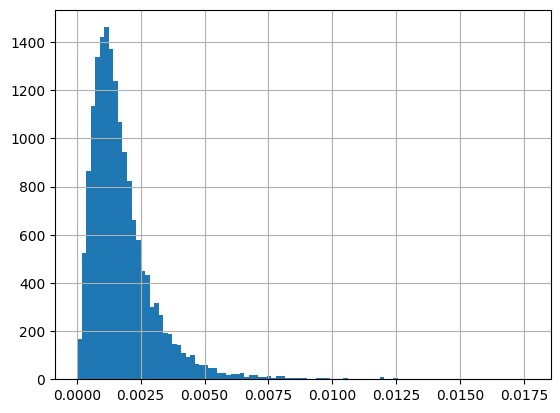

In [ ]:
df_test_str['11_iou'].hist(bins=100)

<Axes: >

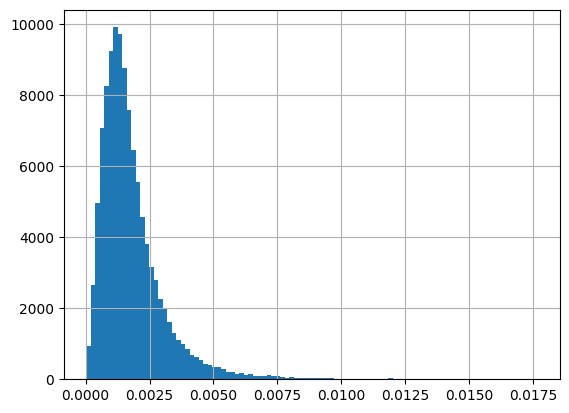

In [ ]:
df_test['11_iou'].hist(bins=100)

In [ ]:
df_test_str

,0,delta_days_order_mean,delta_days_order_min,delta_days_order_max,delta_days_order_std,delta_days_order_nunique,delta_days_order_count,revenue_last,revenue_sum_mean,revenue_sum_sum,...,13_menu_embed_cut16,14_menu_embed_cut16,15_menu_embed_cut16,rest_target_avg,rest_target_max,rest_date_diff_avg,rest_date_diff_max,client_count_avg,client_count_max,customer_id_binarize
customer_id,,,,,,,,,,,,,,,,,,,,,
156357,1,21.000000,5,37,22.627417,2,2,749.95,558.963333,1676.89,...,0.095997,0.036195,0.690956,0.712402,0.721223,31.269231,32.0,461.000000,556,0
161390,3,15.500000,14,17,2.121320,2,2,489.97,780.276667,2340.83,...,0.612446,-0.142267,0.020506,0.776715,0.821438,27.000000,29.0,1111.727273,3853,0
196270,3,2.000000,0,5,1.511858,5,8,219.98,170.208889,1531.88,...,-0.107874,-0.065899,0.176761,0.820521,0.832994,16.157895,17.0,923.894737,982,0
197835,3,16.000000,4,28,16.970563,2,2,329.98,547.633333,1642.90,...,-0.001152,-0.086143,-0.369475,0.825520,0.839662,19.555556,21.0,241.000000,294,0
198718,2,9.500000,8,11,2.121320,2,2,384.95,290.630000,871.89,...,0.371664,-0.410947,0.165191,0.861496,0.861496,16.000000,16.0,361.000000,361,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46389195,2,0.000000,0,0,0.000000,1,3,405.96,398.975000,1595.90,...,0.461434,-0.265490,0.226085,0.907821,0.907821,15.000000,15.0,358.000000,358,23
46400752,2,0.222222,0,1,0.440959,2,9,564.95,346.166000,3461.66,...,0.997258,-0.240733,0.082100,0.904412,0.904412,17.500000,17.5,136.000000,136,23
46464187,4,1.250000,0,4,1.892969,3,4,194.98,107.988000,539.94,...,1.578126,-0.370048,-0.460711,0.917695,1.000000,14.000000,18.0,271.666667,405,23


In [ ]:
df_train = pd.read_csv('df_train_v8.csv')
df_test = pd.read_csv('df_test_v8.csv')



In [ ]:
cols = [str(i) + '_iou' for i in range(1)]

df_train['Target'] = 1
df_test['Target'] = 0

#df_test.drop('customer_id', axis=1, inplace=True)
#df_train.drop([str(i) + '_iou' for i in [61]], axis=1, inplace=True)
#df_test.drop([str(i) + '_iou' for i in [61]], axis=1, inplace=True)
#df_train.drop(['days_of_week_mode'], axis=1, inplace=True)
#df_test.drop(['days_of_week_mode'], axis=1, inplace=True)
# df_train.drop([str(i) + '_menu_embed_cut16' for i in range(16)], axis=1, inplace=True)
# df_test.drop([str(i) + '_menu_embed_cut16' for i in range(16)], axis=1, inplace=True)
#df_train.drop([str(i) + '_iou' for i in [61]], axis=1, inplace=True)
#df_test.drop([str(i) + '_iou' for i in [61]], axis=1, inplace=True)
df = pd.DataFrame()
df = pd.concat([df_train, df_test])
target = df['Target']
df = df.drop('Target', axis=1)

X_train, X_val, y_train, y_val = train_test_split(df[cols], target, test_size=(0.25), random_state=12345)

model = CatBoostClassifier(random_state=13, task_type='CPU', n_estimators=10)

model.fit(X_train, y_train)

print(f1_score(model.predict(X_val), y_val))
f_i = model.get_feature_importance()
f_n = X_train.columns.to_list()
sorted(zip(f_i, f_n))

Learning rate set to 0.5
0:	learn: 0.4395901	total: 64.2ms	remaining: 578ms
1:	learn: 0.3510381	total: 104ms	remaining: 416ms
2:	learn: 0.3106707	total: 169ms	remaining: 394ms
3:	learn: 0.2916707	total: 229ms	remaining: 343ms
4:	learn: 0.2817562	total: 286ms	remaining: 286ms
5:	learn: 0.2770656	total: 327ms	remaining: 218ms
6:	learn: 0.2742895	total: 367ms	remaining: 157ms
7:	learn: 0.2729570	total: 427ms	remaining: 107ms
8:	learn: 0.2721011	total: 464ms	remaining: 51.6ms
9:	learn: 0.2718622	total: 515ms	remaining: 0us
0.9319226247728973


[(100.0, '0_iou')]

<Axes: >

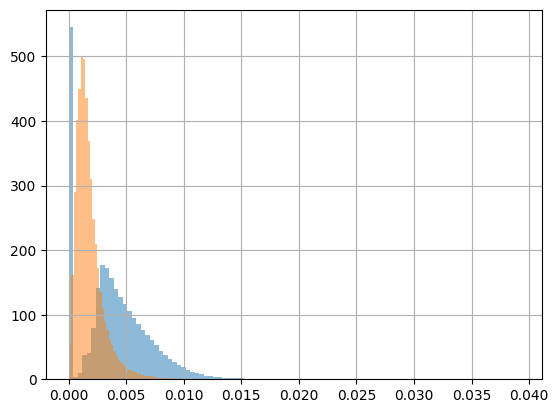

In [ ]:
df_train['0_iou'].hist(bins=100, alpha=0.5, density=True)
df_test['0_iou'].hist(bins=100, alpha=0.5, density=True)

<Axes: >

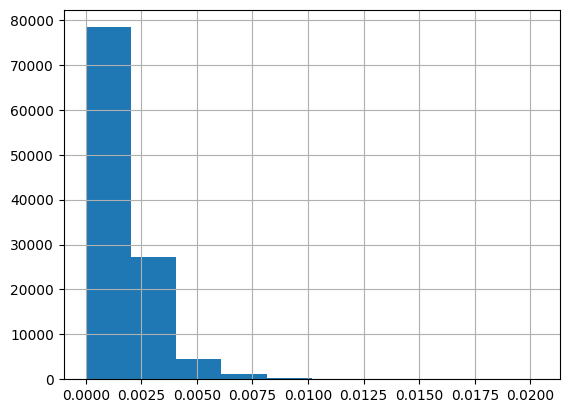

In [ ]:
print(f1_score(model.predict(X_val), y_val))

0.9700098947557796
